In [9]:
from octafilt3r import filter as o3f
from octafilt3r import weightings as o3w
from octafilt3r import plot as o3p
import librosa as lr
import numpy as np
import os
from tensorflow.keras.models import load_model
import pipeline.config as conf
import pipeline.scale as scale

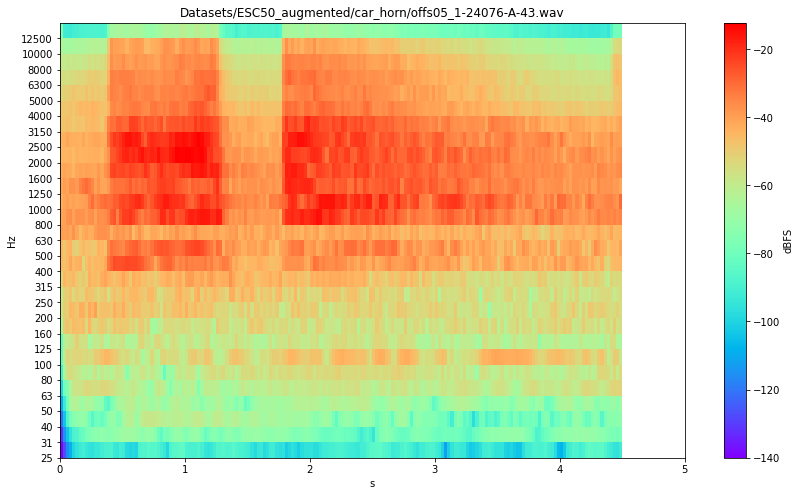

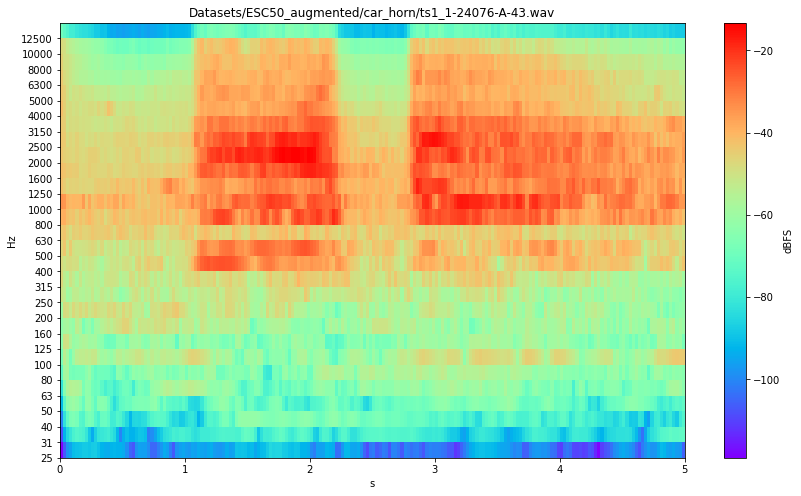

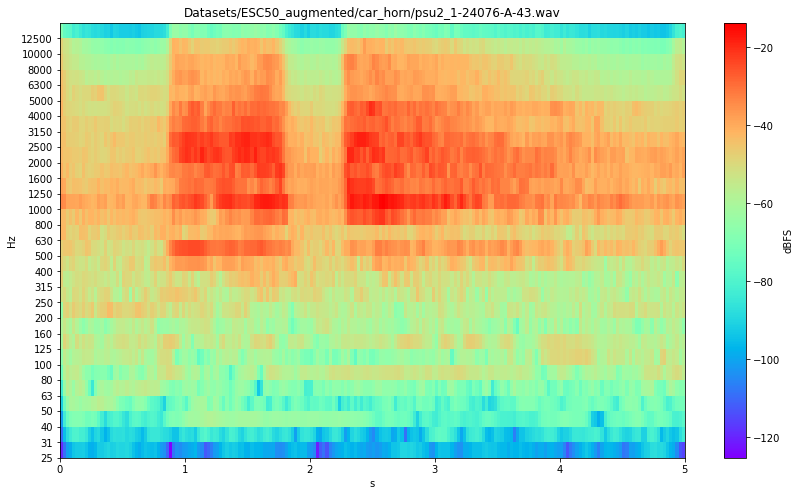

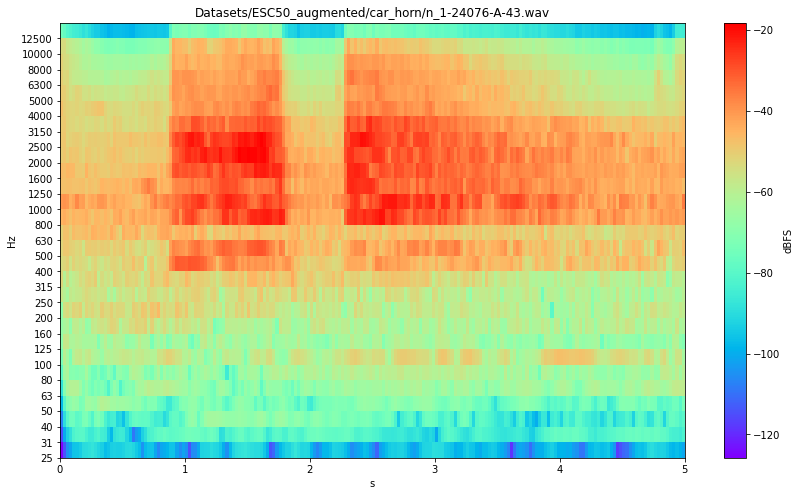

In [10]:
base = "Datasets/ESC50_augmented/car_horn/"
wav1 = base + "offs05_1-24076-A-43.wav"
wav2 = base + "ts1_1-24076-A-43.wav"
wav3 = base + "psu2_1-24076-A-43.wav"
wav4 = base + "n_1-24076-A-43.wav"

df_wav = np.asarray([wav1, wav2, wav3, wav4])
df_y = np.asarray([])

for wav in df_wav:
    y, sr = lr.load(wav, sr=48000, mono=True, duration=5)
    y = o3w.A_weight(y, sr)
    feats, fcs, lq = o3f.rolling_oct_bank(y, 
                                        48000, 
                                        ratio=1/3, 
                                        fmax=12800, 
                                        fmin=20, 
                                        frame_size=1200, 
                                        n_decimations=4)
    o3p.oct_spectrogram(feats, 
                        sr, 
                        1200, 
                        fmax=12800, 
                        fmin=20, 
                        ratio=1/3,
                        name=wav)                                    



In [11]:
import matplotlib.pyplot as plt

param_dict = conf.open_params()
base_path = "Datasets/ESC50_augmented_validate/"
c_matrix = []

model = load_model(param_dict["CNN_name"])

for class_ in os.listdir(base_path):
    cnt = 1
    p_n = []
    for filename in os.listdir(f'{base_path}{class_}'):
        wav, fs = lr.load(base_path + class_ + "/" + filename, sr=param_dict['fs'], duration=5)
        wav = o3w.A_weight(wav, fs)

        feats, fcs, leqs = o3f.rolling_oct_bank(
            wav,
            fs,
            param_dict['oct_bw_ratio'],
            param_dict['order'],
            param_dict['fmax'],
            param_dict['fmin'],
            param_dict['frame_size'],
            param_dict['dec_stages'],
            param_dict['dec_ord']
        )

        feats = feats[:, ::-1]
        df = scale.feats2frames(feats, param_dict['frame_size'], fs)
        df = scale.normalize_dbfs(df, leqs, param_dict["threshold"])
        df = df[..., np.newaxis]

        # o3p.oct_spectrogram(df[0, :, ::-1, 0], 
        #                     fs, 
        #                     param_dict["frame_size"],
        #                     param_dict["fmax"],
        #                     param_dict["fmin"],
        #                     name=filename)
        p = model.predict(df)
        p_n.append(np.mean(p, axis=0))

    print(f"mean of {class_} class matrix: {np.mean(p_n, axis=0)}")
    c_matrix.append(np.mean(p_n, axis=0))

mean of airplane class matrix: [0.71867836 0.04840019 0.03113403 0.14153832 0.0602492 ]
mean of car_horn class matrix: [0.04879925 0.7588428  0.08959817 0.05586238 0.04689734]
mean of engine class matrix: [0.0159758  0.03885815 0.9208692  0.01086286 0.01343404]
mean of helicopter class matrix: [0.15768656 0.05159502 0.03160144 0.7047013  0.05441559]
mean of train class matrix: [0.02452053 0.01394281 0.01374339 0.02585023 0.9219432 ]


(5, 5)


[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'car_horn'),
 Text(0, 2.5, 'engine'),
 Text(0, 3.5, 'helicopter'),
 Text(0, 4.5, 'train')]

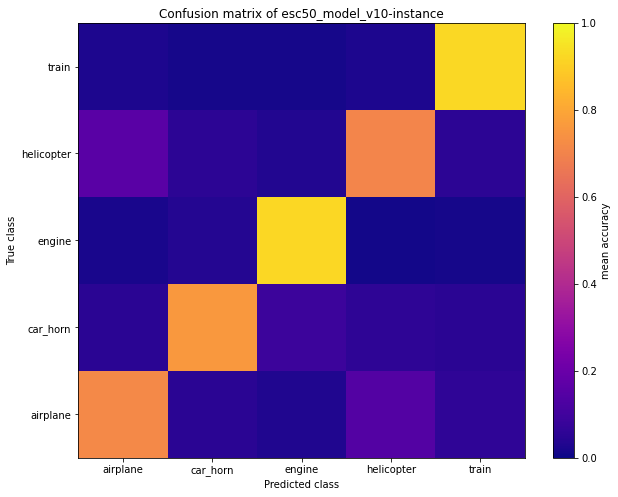

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
print(np.asarray(c_matrix).shape)
plt.pcolormesh(c_matrix, vmin=0, vmax=1, cmap = 'plasma')
plt.title(f"Confusion matrix of {param_dict['CNN_name']}-instance")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar(label='mean accuracy')
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_xticklabels(param_dict["class_map"])
ax.set_yticklabels(param_dict["class_map"])